In [2]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from collections import Counter
import os,re,string,json
from tqdm import tqdm
import pandas as pd
import datetime
import nltk

from functions import *
plotting.style_()

In [3]:
df = pd.read_csv('/home/ruben/Documents/GitHub/parlamint/ngrams/unigrams-gb-week-lemmatized.csv')
df = df.groupby(['month','word']).sum().reset_index()
dfa = df["month word freq".split(' ')].pivot(index='month',columns='word',values='freq').fillna(0.0)

In [4]:
# Select only words that have a minimum frequency in at least one month
filter_ = []

for c in dfa.columns:
    vls = list(dfa[c])
    if len([v for v in vls if v > 25]) > 5 and c not in nltk.corpus.stopwords.words('english'):
        filter_.append(c)
print(f"filtered {len(filter_)} words")

filtered 2243 words


In [5]:
# Normalise
totals = dfa.T 
totals = {m:totals[m].sum() for m in totals.columns}

dfa = dfa.T 
for c in dfa.columns:
    dfa[c] = [x / totals[c] for x in dfa[c]]

dfa = dfa.T

In [6]:
# Apply rolling window and filter
dfa = dfa.rolling(3, win_type='gaussian').sum(std=3)
correlation_matrix = dfa[filter_].corr(method='pearson')

In [14]:
correlation_matrix.sort_values('expert',ascending=False).index[:15]

Index(['expert', 'include', 'already', 'practical', 'centre', 'base',
       'advisory', 'effectiveness', 'prevent', 'proportionate', 'access',
       'outline', 'similar', 'group', 'restrict'],
      dtype='object', name='word')

In [44]:
def plot_words(term,topn=15):
    list_similar = list(correlation_matrix.sort_values('expert',ascending=False).index[:topn])
    d = dfa[list_similar].reset_index()
    d['month'] = [x.replace('-','-W') for x in d['month']]
    d['week'] = [datetime.strptime(x + '-1', "%Y-W%W-%w") for x in d['month']]
    d.sort_values('week').reset_index(drop=True).plot(x='week',y=list_similar,figsize=(20,10),cmap='tab20b')
    return d

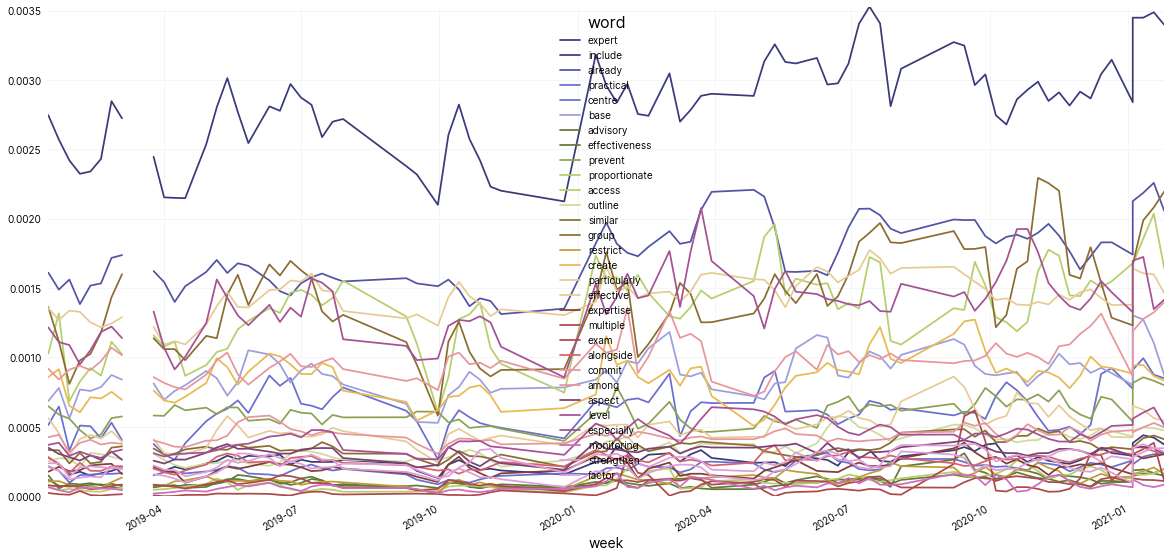

In [46]:
d = plot_words('expert',30)

word,month,expert,include,already,practical,centre,base,advisory,effectiveness,prevent,proportionate,access,outline,similar,group,restrict,week
0,2019-W2,0.000279,0.002746,0.001611,0.000215,0.000513,0.000686,0.000150,0.000119,0.000649,0.000072,0.001028,0.000252,0.000334,0.001363,0.000105,2019-01-14
1,2019-W3,0.000234,0.002570,0.001489,0.000184,0.000647,0.000781,0.000056,0.000076,0.000589,0.000044,0.001318,0.000274,0.000331,0.001116,0.000109,2019-01-21
2,2019-W4,0.000155,0.002420,0.001561,0.000099,0.000330,0.000562,0.000093,0.000070,0.000559,0.000053,0.000685,0.000270,0.000237,0.000810,0.000081,2019-01-28
3,2019-W5,0.000177,0.002324,0.001385,0.000153,0.000510,0.000769,0.000085,0.000074,0.000476,0.000044,0.000827,0.000213,0.000312,0.000979,0.000059,2019-02-04
4,2019-W6,0.000149,0.002340,0.001518,0.000156,0.000505,0.000759,0.000094,0.000082,0.000418,0.000035,0.000923,0.000313,0.000237,0.001025,0.000071,2019-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2020-W53,0.000292,0.002840,0.001742,0.000258,0.000775,0.000801,0.000101,0.000106,0.000538,0.000129,0.001679,0.000431,0.000339,0.001232,0.000141,2021-01-04
79,2021-W1,0.000384,0.003448,0.002126,0.000229,0.000911,0.001304,0.000186,0.000147,0.000816,0.000159,0.001672,0.000473,0.000354,0.001670,0.000160,2021-01-04
80,2021-W2,0.000440,0.003449,0.002186,0.000285,0.000995,0.001273,0.000193,0.000164,0.000857,0.000154,0.001857,0.000496,0.000419,0.001989,0.000181,2021-01-11
81,2021-W3,0.000422,0.003488,0.002258,0.000303,0.000876,0.001105,0.000167,0.000165,0.000832,0.000165,0.002036,0.000491,0.000438,0.002081,0.000208,2021-01-18
